<a href="https://colab.research.google.com/github/WahyuKhairi06/TextMining_WahyuKhairi_2311531009/blob/main/TextMining_WahyuKhairi_2311531009_eng.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Bahasa Inggris**

In [ ]:
from google.colab import drive
import pandas as pd
import numpy as np
import re
import os
from collections import Counter

# Mount Google Drive
drive.mount('/content/drive')
dataset_path = '/content/drive/MyDrive/Informatika/SMT 5/Text Mining/Education(TM).csv'

df = pd.read_csv(dataset_path)
df.head()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,conversation_id_str,created_at,favorite_count,full_text,id_str,image_url,in_reply_to_screen_name,lang,location,quote_count,reply_count,retweet_count,tweet_url,user_id_str,username
0,1964477756412248443,Sat Sep 06 23:59:55 +0000 2025,2,@3orovik The future belongs to platforms that ...,1964478703410565384,NaN,3orovik,en,NaN,0,1,2,https://x.com/undefined/status/196447870341056...,1517108573926526981,NaN
1,1964466486812213253,Sat Sep 06 23:59:54 +0000 2025,0,@GuntherEagleman This is sickening .They come ...,1964478698964529631,NaN,GuntherEagleman,en,NaN,0,0,0,https://x.com/undefined/status/196447869896452...,1931430935175614464,NaN
2,1964478694774452323,Sat Sep 06 23:59:53 +0000 2025,0,Education is the key to unlock the golden doo...,1964478694774452323,https://pbs.twimg.com/media/G0M69enWsAAF5eJ.png,NaN,en,NaN,0,0,0,https://x.com/undefined/status/196447869477445...,1365406735058485251,NaN
3,1964119148088168475,Sat Sep 06 23:59:43 +0000 2025,1,@sellside_ @0HOUR1__ Lack of Moral Education i...,1964478651376030160,NaN,sellside_,en,NaN,0,1,0,https://x.com/undefined/status/196447865137603...,1617667531074048001,NaN
4,1964478641095553395,Sat Sep 06 23:59:40 +0000 2025,1,Google CEO Sundar Pichai announces $120M Globa...,1964478641095553395,NaN,NaN,en,NaN,0,0,0,https://x.com/undefined/status/196447864109555...,1949109461538291712,NaN


In [ ]:
# Try optional libraries, but keep graceful fallbacks
try:
    from nltk.stem import PorterStemmer
    nltk_available = True
except Exception:
    nltk_available = False
    PorterStemmer = None

try:
    # Prefer sklearn's built-in English stopwords to avoid NLTK downloads
    from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS as SK_EN_STOP
    sklearn_available = True
except Exception:
    sklearn_available = False
    SK_EN_STOP = set()

In [ ]:
# Identify likely text column
text_col_candidates = [c for c in df.columns if c.lower() in {"text", "original_text", "tweet", "content", "body"} or "text" in c.lower()]
if not text_col_candidates:
    # If no common name found, pick the first object/string-like column
    object_cols = [c for c in df.columns if df[c].dtype == "object"]
    text_col = object_cols[0] if object_cols else df.columns[0]
else:
    # Prefer 'original_text' then 'text'
    preferred_order = ["original_text", "text"]
    chosen = None
    for p in preferred_order:
        for c in text_col_candidates:
            if c.lower() == p:
                chosen = c
                break
        if chosen: break
    text_col = chosen if chosen else text_col_candidates[0]

# Keep only necessary columns for this run
work = df.copy()
work = work.rename(columns={text_col: "raw_text"})
# Remove rows with empty text
work = work[work["raw_text"].astype(str).str.strip().ne("")].copy()
work.reset_index(drop=True, inplace=True)

# ---------- 1) Case folding (lowercasing) ----------
work["lower"] = work["raw_text"].astype(str).str.lower()

In [ ]:
# ---------- 1) Case folding (lowercasing) ----------
work["lower"] = work["raw_text"].astype(str).str.lower()

In [ ]:
# ---------- 2) Cleaning (remove urls, mentions, hashtags, emoji, extra spaces) ----------
# URL pattern
url_pattern = re.compile(r"http\S+|www\.\S+")
# Mentions (@user) and hashtags (#topic) -> remove tokens starting with @ or #
mention_hashtag_pattern = re.compile(r"[@#]\w+")
# Emoji removal via unicode ranges (broad)
emoji_pattern = re.compile(
    "["
    u"\U0001F600-\U0001F64F"  # emoticons
    u"\U0001F300-\U0001F5FF"  # symbols & pictographs
    u"\U0001F680-\U0001F6FF"  # transport & map symbols
    u"\U0001F1E0-\U0001F1FF"  # flags
    u"\U00002700-\U000027BF"  # dingbats
    u"\U000024C2-\U0001F251"
    "]+",
    flags=re.UNICODE,
)
# Remove punctuation except spaces/apostrophes inside words we will normalize later
punct_pattern = re.compile(r"[^\w\s']")

def clean_text(s: str) -> str:
    s = url_pattern.sub(" ", s)
    s = mention_hashtag_pattern.sub(" ", s)
    s = emoji_pattern.sub(" ", s)
    s = punct_pattern.sub(" ", s)
    # collapse whitespace
    s = re.sub(r"\s+", " ", s).strip()
    return s

work["clean"] = work["lower"].map(clean_text)


In [ ]:
# ---------- 3) Tokenization ----------
token_pattern = re.compile(r"\b\w+\b")

def tokenize(s: str):
    return token_pattern.findall(s)

work["tokens"] = work["clean"].map(tokenize)

In [ ]:
# ---------- 4) Normalization (slang/abbrev -> standard) ----------
normalize_map = {
    "u": "you",
    "ur": "your",
    "r": "are",
    "pls": "please",
    "plz": "please",
    "idk": "i do not know",
    "imo": "in my opinion",
    "imho": "in my humble opinion",
    "btw": "by the way",
    "lmk": "let me know",
    "omg": "oh my god",
    "thx": "thanks",
    "ty": "thank you",
    "tho": "though",
    "bc": "because",
    "bcoz": "because",
    "bcz": "because",
    "gonna": "going to",
    "wanna": "want to",
    "gotta": "got to",
    "kinda": "kind of",
    "sorta": "sort of",
    "cant": "cannot",
    "dont": "do not",
    "doesnt": "does not",
    "isnt": "is not",
    "arent": "are not",
    "wasnt": "was not",
    "werent": "were not",
    "shouldnt": "should not",
    "couldnt": "could not",
    "wouldnt": "would not",
    "yall": "you all",
    "ppl": "people",
    "uni": "university",
    "dept": "department",
    "prof": "professor",
    "edu": "education",
}

def normalize_tokens(tokens):
    out = []
    for t in tokens:
        # expand basic english contractions without relying on nltk
        t = normalize_map.get(t, t)
        out.extend(t.split())  # in case expansion has spaces
    return out

work["tokens_norm"] = work["tokens"].map(normalize_tokens)


In [ ]:
# ---------- 5) Stopword removal ----------
base_stop = set(SK_EN_STOP) if sklearn_available else set()
# Add some task-specific extras (common words in tweets)
extra_stop = {
    "rt","co","https","amp","im","ive","ya","ok","okay","today","one","two","us","yes","no"
}
stopwords = base_stop.union(extra_stop)

def remove_stopwords(tokens):
    return [t for t in tokens if t not in stopwords and not t.isdigit()]

work["tokens_nostop"] = work["tokens_norm"].map(remove_stopwords)


In [ ]:
# ---------- 6) Stemming (Porter) ----------
if nltk_available and PorterStemmer is not None:
    stemmer = PorterStemmer()
    def stem_tokens(tokens):
        return [stemmer.stem(t) for t in tokens]
else:
    # Fallback: no stemming if NLTK is unavailable
    def stem_tokens(tokens):
        return tokens

work["tokens_stem"] = work["tokens_nostop"].map(stem_tokens)

In [ ]:
# ---------- 7) Quick summaries ----------
work["len_tokens_before"] = work["tokens"].map(len)
work["len_tokens_after"] = work["tokens_stem"].map(len)

summary = {
    "rows": len(work),
    "columns": list(df.columns),
    "chosen_text_column": text_col,
    "avg_tokens_before": float(np.mean(work["len_tokens_before"])) if len(work) else 0.0,
    "avg_tokens_after": float(np.mean(work["len_tokens_after"])) if len(work) else 0.0,
    "n_empty_after_clean": int((work["clean"].str.len() == 0).sum())
}

In [ ]:
# ---------- 8) Top term frequencies (after preprocessing) ----------
all_tokens = [t for tokens in work["tokens_stem"] for t in tokens]
freq = Counter(all_tokens)
top_terms = pd.DataFrame(freq.most_common(25), columns=["term", "freq"])

In [ ]:
# ---------- 9) Save outputs ----------
out_dir = "/mnt/data"
os.makedirs(out_dir, exist_ok=True)

In [ ]:
# Save a compact preprocessed CSV
out_cols = ["raw_text","clean","tokens","tokens_norm","tokens_nostop","tokens_stem","len_tokens_before","len_tokens_after"]
save_df = work[out_cols].copy()
# convert lists to space-joined strings for CSV readability
for c in ["tokens","tokens_norm","tokens_nostop","tokens_stem"]:
    save_df[c] = save_df[c].apply(lambda x: " ".join(x))

preprocessed_path = os.path.join(out_dir, "education_preprocessed_en.csv")
save_df.to_csv(preprocessed_path, index=False, encoding="utf-8")

sample_path = os.path.join(out_dir, "education_sample_preview.csv")
work_sample = work.head(20)[["raw_text","clean","tokens","tokens_stem"]].copy()
for c in ["tokens","tokens_stem"]:
    work_sample[c] = work_sample[c].apply(lambda x: " ".join(x))
work_sample.to_csv(sample_path, index=False, encoding="utf-8")

In [ ]:
# Use standard display for the preview
display(work.head(50)[["raw_text","clean","tokens","tokens_stem"]])

# Return the text summary and file paths for download
(summary, preprocessed_path, sample_path)

,raw_text,clean,tokens,tokens_stem
0,@3orovik The future belongs to platforms that ...,the future belongs to platforms that merge fin...,"[the, future, belongs, to, platforms, that, me...","[futur, belong, platform, merg, financ, ai, ed..."
1,@GuntherEagleman This is sickening .They come ...,this is sickening they come uninvited to our c...,"[this, is, sickening, they, come, uninvited, t...","[sicken, come, uninvit, countri, british, taxp..."
2,Education is the key to unlock the golden doo...,education is the key to unlock the golden door...,"[education, is, the, key, to, unlock, the, gol...","[educ, key, unlock, golden, door, freedom, geo..."
3,@sellside_ @0HOUR1__ Lack of Moral Education i...,lack of moral education in hole generation,"[lack, of, moral, education, in, hole, generat...","[lack, moral, educ, hole, gener]"
4,Google CEO Sundar Pichai announces $120M Globa...,google ceo sundar pichai announces 120m global...,"[google, ceo, sundar, pichai, announces, 120m,...","[googl, ceo, sundar, pichai, announc, 120m, gl..."
5,The War on Afghan Women: A Deliberate Strategy...,the war on afghan women a deliberate strategy ...,"[the, war, on, afghan, women, a, deliberate, s...","[war, afghan, women, deliber, strategi, taliba..."
6,@Komanoff @tomwatson Wait. So he is going to p...,wait so he is going to put off his education w...,"[wait, so, he, is, going, to, put, off, his, e...","[wait, go, educ, run, do, oligarch, tour, nope..."
7,@Asoye_yoruba Based on your Yoruba culture-pro...,based on your yoruba culture promoting tweets ...,"[based, on, your, yoruba, culture, promoting, ...","[base, yoruba, cultur, promot, tweet, dictat, ..."
8,Capitalists fund education &amp; cooperation e...,capitalists fund education amp cooperation eco...,"[capitalists, fund, education, amp, cooperatio...","[capitalist, fund, educ, cooper, ecovillag, gl..."
9,All of us agree that overall in measurable eco...,all of us agree that overall in measurable eco...,"[all, of, us, agree, that, overall, in, measur...","[agre, overal, measur, econom, term, south, af..."


({'rows': 303,
  'columns': ['conversation_id_str',
   'created_at',
   'favorite_count',
   'full_text',
   'id_str',
   'image_url',
   'in_reply_to_screen_name',
   'lang',
   'location',
   'quote_count',
   'reply_count',
   'retweet_count',
   'tweet_url',
   'user_id_str',
   'username'],
  'chosen_text_column': 'full_text',
  'avg_tokens_before': 30.09240924092409,
  'avg_tokens_after': 15.735973597359736,
  'n_empty_after_clean': 0},
 '/mnt/data/education_preprocessed_en.csv',
 '/mnt/data/education_sample_preview.csv')

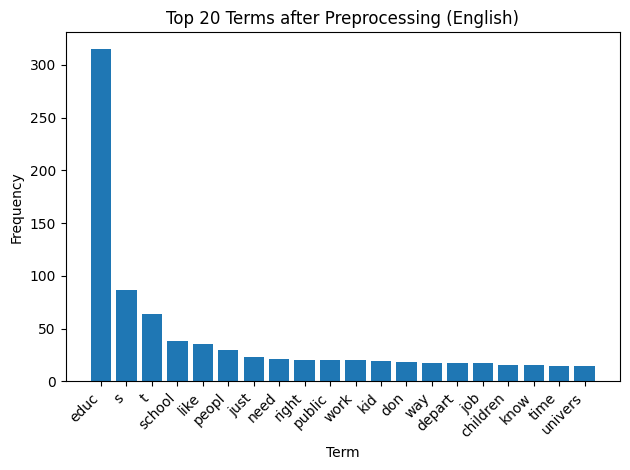

,raw_text,clean
0,@3orovik The future belongs to platforms that ...,the future belongs to platforms that merge fin...
1,@GuntherEagleman This is sickening .They come ...,this is sickening they come uninvited to our c...
2,Education is the key to unlock the golden doo...,education is the key to unlock the golden door...
3,@sellside_ @0HOUR1__ Lack of Moral Education i...,lack of moral education in hole generation
4,Google CEO Sundar Pichai announces $120M Globa...,google ceo sundar pichai announces 120m global...
5,The War on Afghan Women: A Deliberate Strategy...,the war on afghan women a deliberate strategy ...
6,@Komanoff @tomwatson Wait. So he is going to p...,wait so he is going to put off his education w...
7,@Asoye_yoruba Based on your Yoruba culture-pro...,based on your yoruba culture promoting tweets ...
8,Capitalists fund education &amp; cooperation e...,capitalists fund education amp cooperation eco...
9,All of us agree that overall in measurable eco...,all of us agree that overall in measurable eco...


In [ ]:
# Produce a bar chart of top 20 term frequencies (after preprocessing)
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import os

# Reload the work DataFrame from the previously saved preprocessed CSV for reproducibility
preprocessed_path = "/mnt/data/education_preprocessed_en.csv"
pre = pd.read_csv(preprocessed_path)

# Turn space-joined tokens back into lists for counting
pre["tokens_stem_list"] = pre["tokens_stem"].fillna("").apply(lambda s: [t for t in s.split() if t])

# Count top terms
all_tokens = [t for row in pre["tokens_stem_list"] for t in row]
freq = Counter(all_tokens)
top20 = freq.most_common(20)
terms = [t for t, _ in top20]
counts = [c for _, c in top20]

# Plot single bar chart (no specific colors or styles set)
plt.figure()
plt.bar(terms, counts)
plt.title("Top 20 Terms after Preprocessing (English)")
plt.xlabel("Term")
plt.ylabel("Frequency")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# Save 50 example tweets (raw & clean) filtered to English if 'lang' column exists
# Use the original dataframe 'df' which was loaded from the correct path
col_map = {c:c for c in df.columns}
# pick text column
text_col = "full_text" if "full_text" in df.columns else ( "text" if "text" in df.columns else df.columns[0] )
examples = pd.DataFrame({"raw_text": df[text_col].astype(str)})
if "lang" in df.columns:
    mask = df["lang"].astype(str).str.lower().eq("en")
    examples = examples[mask].copy()

# Merge to get the cleaned version
examples = examples.merge(pre[["raw_text","clean","tokens_stem"]], on="raw_text", how="left").dropna(subset=["clean"])
# Deduplicate and take top 50
examples = examples.drop_duplicates(subset=["raw_text"]).head(50)
examples_path = os.path.join("/mnt/data", "education_en_examples_for_report.csv")
examples.to_csv(examples_path, index=False, encoding="utf-8")

display(examples.head(10)[["raw_text","clean"]])

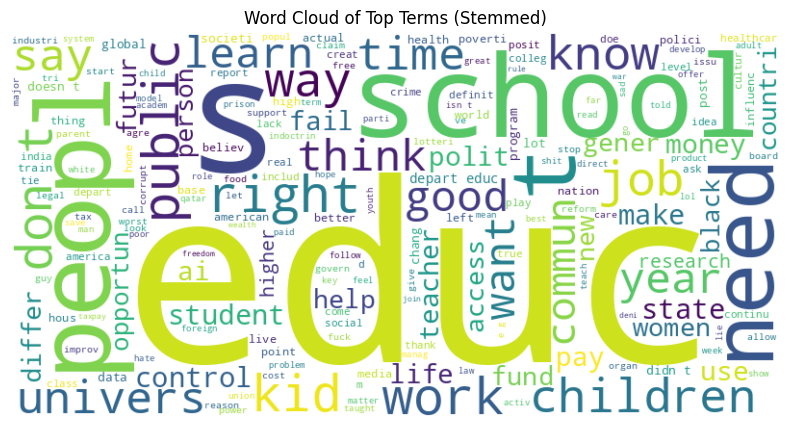

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import pandas as pd
import os

# Load the preprocessed data
preprocessed_path = "/mnt/data/education_preprocessed_en.csv"

# Check if the file exists before attempting to read it
if os.path.exists(preprocessed_path):
    pre = pd.read_csv(preprocessed_path)

    # Combine all stemmed tokens into a single string
    all_stemmed_text = " ".join(pre["tokens_stem"].dropna())

    # Generate the word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_stemmed_text)

    # Display the word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Word Cloud of Top Terms (Stemmed)')
    plt.show()
else:
    print(f"Error: File not found at {preprocessed_path}")